# Discrete probability measures: fair vs. loaded dice

Authors: Dinesh Krishna Natarajan (dinesh_krishna.natarajan@dfki.de), Felix Fritzen (fritzen@simtech.uni-stuttgart.de)
   
additional material for the course *Data processing for engineers and scientists* at the University of Stuttgart

# Fair and loaded dice using numpy

- drawing cards from a deck using a fair dice (uniformly distributed probabilities)
- drawing cards from a deck using loaded dice (select cards have biased probabilities) *(German: "gezinkte Karten/Würfel")*


In [2]:
import numpy as np
import math

## Creating the deck of cards

- a standard card deck contains 52 cards with 4 suits containing 13 cards each
- each suit has: `{ A, 2, 3, 4, 5, 6, 7, 8, 9, 10, J, Q, K}` \
where  `{ A, J, Q, K }` stand for ace, jack, queen and king, respectively

<figure>
    <center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/AcetoFive.JPG/1200px-AcetoFive.JPG" width=500 height=500 />
    <figcaption>Playing cards (<a href="https://en.wikipedia.org/wiki/Playing_card">image source</a>).</figcaption>
    </center>
</figure>

In [3]:
import collections

def get_iterable(x):
    if isinstance(x, collections.abc.Iterable):
        return x
    else:
        return [x]
    
# utility function for naming cards
def card_name( i ):
    color = [ 'Diamonds', 'Hearts  ', 'Spades  ', 'Clubs   ']
    cards = [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
    first = 1
    name = ''
    i = get_iterable(i)
    for j in i:
        if( first == 0 ):
            name = name + '; '
        name  = name + color[int(np.mod(j/13, 4))] + ' ' + cards[np.mod(j, 13)]
        first = 0
    return name

# illustrate the meaning of the above function
print('Six random cards from the deck:')
for j in np.random.randint( 0, 52, 6):
    print(card_name(j))


# Defining the deck of cards using a 1D array of length 52
deck_of_cards = np.arange(52)
print('\nDeck of cards printed in 2D:\n', deck_of_cards.reshape(4,13))
print()

print('Deck of cards printed using human readable names:')
for j in deck_of_cards:
    print('card %2d:  %s' %(j+1, card_name(j)))

Sample cards:
Hearts   3
Clubs    J
Clubs    4
Clubs    8
Hearts   10
Spades   8

Deck of cards printed in 2D:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [13 14 15 16 17 18 19 20 21 22 23 24 25]
 [26 27 28 29 30 31 32 33 34 35 36 37 38]
 [39 40 41 42 43 44 45 46 47 48 49 50 51]]

Deck of cards printed using human readable names:
card  1:  Diamonds A
card  2:  Diamonds 2
card  3:  Diamonds 3
card  4:  Diamonds 4
card  5:  Diamonds 5
card  6:  Diamonds 6
card  7:  Diamonds 7
card  8:  Diamonds 8
card  9:  Diamonds 9
card 10:  Diamonds 10
card 11:  Diamonds J
card 12:  Diamonds Q
card 13:  Diamonds K
card 14:  Hearts   A
card 15:  Hearts   2
card 16:  Hearts   3
card 17:  Hearts   4
card 18:  Hearts   5
card 19:  Hearts   6
card 20:  Hearts   7
card 21:  Hearts   8
card 22:  Hearts   9
card 23:  Hearts   10
card 24:  Hearts   J
card 25:  Hearts   Q
card 26:  Hearts   K
card 27:  Spades   A
card 28:  Spades   2
card 29:  Spades   3
card 30:  Spades   4
card 31:  Spades   5
card 32:  Spade

## Drawing cards from the deck

- using the function [`numpy.random.choice( array, length )`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), a subset of a specific `length` (i.e. number of samples) can be drawn from a 1D array `array`
- using the argument `replace=False`, the sample space of the deck decreases as each card is drawn. This avoids drawing duplicates. 


In [7]:
# Draw a subset of cards of length 'num_cards' from the deck without replacement
num_cards    = 7
chosen_cards = np.random.choice( deck_of_cards, size=num_cards, replace=False )
chosen_cards = np.sort( chosen_cards )

print('Chosen cards')
print( card_name(chosen_cards)) 

Chosen cards
Diamonds 5; Diamonds J; Spades   2; Spades   4; Spades   5; Spades   9; Clubs    3


## Defining a card game

- assuming a card game where drawing aces is favorable, it can be tempting to load the dice in favor of aces
- The aces in this deck of cards are: `[0, 13, 26, 39]`

In [8]:
aces        = np.arange(0,4) * 13
# Using set difference to retrieve the other cards from the deck
other_cards = np.setdiff1d( deck_of_cards, aces )

print('Aces:', card_name(aces))

Aces: Diamonds A; Hearts   A; Spades   A; Clubs    A


## Drawing probabilities of each card

- the argument `p` of `numpy.random.choice` defines the probabilites associated with each element of the 1D array. 
- By default, a uniform distribution over all elements is used. 
- Thus, a fair dice ensures a uniform probability for drawing each card from the deck. 

## 'Loading the dice'
by manipulating the probabilities of each entry, the chances of drawing the desired cards can be unfairly increased

#### load_dice function:

- this function loads the dice in favor of aces
- the argument `overweight` defines the premultiplier in the following expression: 
$ P( \text{one [any] ace} ) = \text{overweight}\; \times P( \text{any other card} ) $
- the probabilities have to be normalized such that: 
$ P( \text{deck of cards} ) = 1\; $ or $\; \sum P( \text{card} ) = 1 $ 
- the function returns `loaded_dice`: the unfair probabilities for all cards



In [11]:
def load_dice( overweight, aces, deck_size = 52 ):
    """
    returns the probabilities of all cards in the deck
    
    INPUT
    -----
    overweight      float (>= 0)
                    relative probability of finding an ace vs. another card
                    1  -> no overweight
                    <1 -> underweight
                    >1 -> bias towards aces
    
    aces            numpy.array (1-d, int)
                    indices of aces in the deck
                    
    deck_size       int (>=0)
                    number of cards in the deck
    """
    assert( deck_size > 0)
    assert( deck_size >= np.max(aces) )
    assert( overweight >= 0 )
    
    loaded_dice                = np.ones( deck_size, dtype=float)
    loaded_dice[ aces ]        = overweight
    # normalize probabilities
    loaded_dice                = loaded_dice / np.sum( loaded_dice )
    
    return loaded_dice

- get a loaded dice with a desired `overweight` value for the aces
- check for normalization property of a discrete probability measure $P\,$:  $\; \sum P( \text{card} ) = 1 $ 

In [12]:
overweight        = 3.
loaded_dice       = load_dice( overweight, aces, deck_size=52 )
sum_probabilities = loaded_dice.sum() 
tol_factor        = 3

print('Loaded dice printed in 2D:')
with np.printoptions( precision=4 ):
    print( loaded_dice.reshape(4,13) )
print('\nP( deck of cards ) = ', sum_probabilities)

# Check for normalization property
deviation = np.abs(sum_probabilities-1.0)
if not deviation == 0 :
    # check if deviation is of the order of machine precision
    if math.isclose( deviation, 0, abs_tol=tol_factor*1e-16 ):
        print('Deviation is less than {} times machine precision'.format( tol_factor ))
    else:
        raise ValueError('Deviation is greater than machine precision! Normalization property is NOT satisfied!')

print('The loaded dice is a discrete probability measure!')

Loaded dice printed in 2D:
[[0.05   0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167
  0.0167 0.0167 0.0167]
 [0.05   0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167
  0.0167 0.0167 0.0167]
 [0.05   0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167
  0.0167 0.0167 0.0167]
 [0.05   0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167 0.0167
  0.0167 0.0167 0.0167]]

P( deck of cards ) =  1.0000000000000002
Deviation is less than 3 times machine precision
The loaded dice is a discrete probability measure!


### Note
- the assertion error is raised in cases where the deviation of `sum_probabilities` is more than the specified multiple of machine precision off from `1.0`
- the normalization property is bit-exactly satisfied (no numerical truncation) when the sum of the `loaded_dice` before normalization is a power of 2, i.e., when\
$$ n_\mathsf{aces} (o -1) + n_\mathsf{other} =\, 2^n $$
- try other values for `overweight` ($o$)

## Fair dice vs. Loaded dice
- `num_cards` are drawn to see the `loaded_dice` in action against a fair dice

In [13]:
num_cards    = 7
fair_cards   = np.random.choice( deck_of_cards, size=num_cards, replace=False )
unfair_cards = np.random.choice( deck_of_cards, size=num_cards, replace=False, p=loaded_dice )
fair_cards   = np.sort( fair_cards )
unfair_cards = np.sort( unfair_cards )

# Check for aces in fair cards:
print('Fairly chosen cards:\n', fair_cards)
fair_aces = np.intersect1d( fair_cards, aces )
if len( fair_aces ) > 0:
    print("{} Ace(s):  {}! \nLooks like we didn't need the loaded dice afterall!\n".format(len( fair_aces ), 
                                                                                           card_name(fair_aces)))
else:
    print('No ace! Maybe there is better luck with the loaded dice\n')
    
# Check for aces in unfair cards: 
print('Unfairly chosen cards:\n', unfair_cards)
unfair_aces = np.intersect1d( unfair_cards, aces )
if len( unfair_aces ) > 0:
    print('{} Ace(s):  {}! \nThe loaded dice worked!'.format(len( unfair_aces ), card_name(unfair_aces)))
else:
    print('No ace! Maybe the loaded dice needs more loading!')

Fairly chosen cards:
 [ 8 10 12 14 25 29 39]
1 Ace(s):  Clubs    A! 
Looks like we didn't need the loaded dice afterall!

Unfairly chosen cards:
 [ 5 13 15 24 26 38 39]
3 Ace(s):  Hearts   A; Spades   A; Clubs    A! 
The loaded dice worked!


## Statistics of the card game
- observing the card game between a `fair_player` and an `unfair_player`
- analyse the total aces drawn and rounds won by each player over several rounds

### card_game function
- represents `num_rounds` rounds of the card game where each player draws `num_cards` consecutive cards from a plain deck, the number of aces are counted and a winner is chosen
- arguments:

| name            | description |
|:---------------:|:------------|
| `num_cards`     | int, number of cards to be drawn |
| `num_rounds`    | int, number of rounds of the card game |
| `deck_of_cards` | 1D array of the deck of cards |
| `aces`          | 1D array of the aces |
| `loaded_dice`   | 1D array of the loaded dice defined by load_dice function |

- returns a dictionary `results` with the following entries:

| name                | description |
|:-------------------:|:------------|
| `aces_fair`         | 1D array, number of aces drawn by the fair player in each round of the game|
| `aces_unfair`       | 1D array, number of aces drawn by the unfair player in each round of the game|
| `wins_fair`         | int, total rounds won by the fair player|
| `wins_unfair`       | int, total rounds won by the unfair player|
| `ties`              | int, total rounds which were ties between the players |

In [14]:
def card_game( num_cards, num_rounds, deck_of_cards, aces, loaded_dice ):
    """
    returns a dictionary of results of a card game as described above
       
    """
    aces_fair   = []
    aces_unfair = []
    wins_fair   = 0
    wins_unfair = 0
    ties        = 0
    for round_ in range(num_rounds):
        # each player draws cards from their deck using their dice
        fair_cards   = np.random.choice( deck_of_cards, size=num_cards, replace=False )
        unfair_cards = np.random.choice( deck_of_cards, size=num_cards, replace=False, p=loaded_dice )
        # Count number of aces
        aces_fair.append(   len( np.intersect1d(   fair_cards, aces ) ) )
        aces_unfair.append( len( np.intersect1d( unfair_cards, aces ) ) )
        # Decide the winner (if any)
        if aces_fair[-1]   > aces_unfair[-1]: 
            wins_fair   += 1
        elif aces_fair[-1] < aces_unfair[-1]:
            wins_unfair += 1
        else: # equal no. of aces 
            ties        += 1
                
    # Create a dictionary with the return variables
    results = {}
    results['aces_fair']   = np.array( aces_fair   )
    results['aces_unfair'] = np.array( aces_unfair )
    results['wins_fair']   = wins_fair
    results['wins_unfair'] = wins_unfair
    results['ties']        = ties    
    
    return results   
        

## Card Game Experiment
- define the input arguments for the card_game function that define the conditions of the game
- observe the results

In [15]:
# game conditions
num_cards       = 7
num_rounds      = 1000
overweight      = 2.
aces            = np.arange(0,4) * 13
loaded_dice     = load_dice( overweight, aces, deck_size=52 )
game_conditions = [ num_cards, num_rounds, deck_of_cards, aces, loaded_dice]

# running the experiment
results = card_game( *game_conditions )

print('Results from {} rounds of the card game between a fair and loaded dice'.format(num_rounds))
print('Total aces drawn by fair player  :', results['aces_fair'].sum() )
print('Total aces drawn by unfair player:', results['aces_unfair'].sum() )
print('Total rounds won by fair player  :', results['wins_fair'])
print('Total rounds won by unfair player:', results['wins_unfair'])
print('Total rounds that ended in a tie :', results['ties'])

Results from 1000 rounds of the card game between a fair and loaded dice
Total aces drawn by fair player  : 540
Total aces drawn by unfair player: 972
Total rounds won by fair player  : 172
Total rounds won by unfair player: 487
Total rounds that ended in a tie : 341


## Visualization

Desired cards / 'aces':
Diamonds A
Hearts   A
Spades   A
Clubs    A


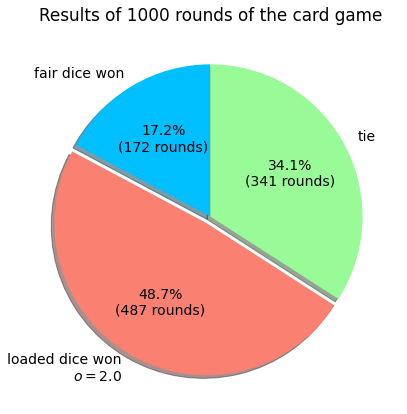

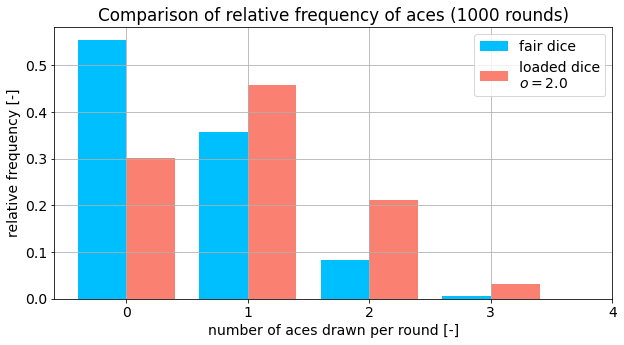

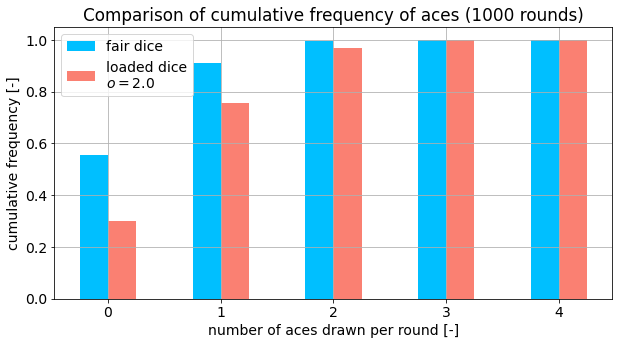

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '14'

## Print the desired cards to be drawn
print("Desired cards / 'aces':")
for ace in aces:
    print(card_name(ace))

## Pie Chart setup
pie_labels  = 'fair dice won', 'loaded dice won' + '\n$o={}$'.format(overweight) , 'tie'
pie_sizes   = [ results['wins_fair'], results['wins_unfair'], results['ties'] ]
pie_explode = ( 0, 0.05, 0)
pie_colors  = ['deepskyblue','salmon','palegreen']

# function to assign labels for the pie chart
def get_labels(pct, sizes):
    """
    returns the formatted label string (size in % and value) associated with each pie
    INPUT:
    pct   - float, size of the pie in percentage
    sizes - 1D array containing sizes of the pies
    """
    size = int( round( pct/100. * np.sum(sizes) ) ) 
    return "{:.1f}%\n({:d} rounds)".format(pct, size)

# Plotting pie chart
plt.figure(figsize=(7,7))
plt.pie( pie_sizes, explode=pie_explode, labels=pie_labels, colors=pie_colors, startangle=90, shadow=True,
                                                            autopct=lambda pct: get_labels(pct, pie_sizes) )
plt.title('Results of {} rounds of the card game'.format(num_rounds))

## Distribution of number of aces drawn by each dice
# Get number of bins based on the range of the distribution
lower_limit_bins = np.min([results['aces_fair'], results['aces_unfair']])
upper_limit_bins = np.max([results['aces_fair'], results['aces_unfair']])
# Center the number of bins on the discrete integer values
bins = np.arange( lower_limit_bins, upper_limit_bins + 1.5 ) - 0.5

# Plotting the relative frequency
plt.figure(figsize=(10,5))
plt.grid()
plt.hist( [results['aces_fair'], results['aces_unfair']], label=['fair dice','loaded dice\n$o={}$'.format(overweight)], 
          color=['deepskyblue','salmon'], bins=bins, density=True )
plt.xlabel('number of aces drawn per round [-]')
plt.xticks(np.arange(len(aces)+1))
plt.ylabel('relative frequency [-]')
plt.legend()
plt.title('Comparison of relative frequency of aces (%d rounds)' % num_rounds);

## Function to compute the cumulative frequencies
def cumulative_frequencies( aces_drawn, aces_num, num_rounds ):
    """
    returns the cumulative frequencies of drawing N belongs to {0,1...,4} aces over num_rounds    
    INPUTS:
    aces_drawn  -   1D array containing the number of aces drawn in each round
    aces_num    -   int describing the length of the desired cards subset 
                    (scope for expanding to larger subsets, e.g. 'aces'={aces, kings})
    num_rounds  -   int describing the number of rounds of the card game played    
    RETURNS: 
    cumul_freq  -   1D array containing the cumulative frequencies of drawing 
                    0,1,2,3 and 4 aces during the card game
    """
    # Get counts of each possible number of aces drawn during the game {0,1,...}
    _, count_aces = np.unique( aces_drawn, return_counts=True)
    
    # Ensure count_aces has a length = length of the set of possible number of aces {0,1,...,4}
    # for e.g.: if 4 aces were never drawn during the game, the count_aces has to be expanded by 1
    difference = (aces_num+1) - len(count_aces)
    if difference > 0:
        count_aces = np.concatenate( (count_aces, np.zeros(difference)) )
    elif difference < 0:
        raise ValueError('Double check the argument aces_num!')
    
    # Calculate cumulative frequency
    cumul_freq  = count_aces.cumsum() / num_rounds
    
    return cumul_freq

# Get cumulative frequencies
cumul_freq_fair   = cumulative_frequencies( results['aces_fair'],   len(aces), num_rounds )
cumul_freq_unfair = cumulative_frequencies( results['aces_unfair'], len(aces), num_rounds )

# Plotting the cumulative frequency
plt.figure(figsize=(10,5))
plt.grid()
plt.bar( np.arange(len(aces)+1)-0.125, cumul_freq_fair, color='deepskyblue', width=0.25, label='fair dice'  )
plt.bar( np.arange(len(aces)+1)+0.125, cumul_freq_unfair, color='salmon', width=0.25, 
                                                          label='loaded dice\n$o={}$'.format(overweight))
plt.xlabel('number of aces drawn per round [-]')
plt.xticks(np.arange(len(aces)+1))
plt.ylabel('cumulative frequency [-]')
plt.legend()
plt.title('Comparison of cumulative frequency of aces (%d rounds)' % num_rounds);


# Voluntary tasks
- compute the theoretical probabilities for number of aces $N \in \{0, \dots, 4\}$: $P(N=0), \dots, P(N=4)$
- compare the theoretical values to the relative frequencies for different `num_rounds`
- what is the scaling of the dispersion around the theoretical value as a function of `num_rounds`?
- compute the probability for a tie between two fair dices
- *Coding*: Expand the `aces` to include more desired cards and repeat the card game